# Let's generate some synthetic data

We'll use the O-SPLAT model with a pretty simple $v$ parameter. We can later try to use this for testing inference.

In [2]:
import numpy as np
np.random.seed(12345)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update({
    "text.usetex": True,
})

import scipy.stats as stats

Start by assuming a sampling rate $\Delta t$ of 1 ms, so that the Nyquist frequency is 500 Hz. In practice, we will not be interested in anything above 125 Hz (unless we consider high gamma).

Since the signal is real, we need $v^*_{\omega, t} = v_{-\omega, t}$, and we'll start by assuming no phase delays (i.e., $v$ is real).

We'll start with three latent patterns, each with power peaked around a particular frequency.

In [13]:
max_freq = 250  # maximum (absolute value) frequency we care about
Nlat = 3  # number of latent patterns
N = 1000  # number of samples
dt = 0.001  # sample spacing (in s)

freqs = np.fft.fftshift(np.fft.fftfreq(N, dt))
print(f"Max frequency: {np.max(freqs)}, Min frequency: {np.min(freqs)}")

Max frequency: 499.0, Min frequency: -500.0


As expected, the max and min frequencies are the Nyquist frequency. Note that these are linear frequencies $f$, not angular frequencies $\omega$ because of the [FFT definition used by NumPy](https://numpy.org/doc/stable/reference/routines.fft.html#implementation-details).

In [45]:
center_freqs = [5, 25, 60]  # peak power frequencies of each latent
center_std = [.1, .5, 1.5]

all_v = []
for mu, sig in zip(center_freqs, center_std):
    right = stats.norm.pdf(freqs, loc=mu, scale=sig)
    left = stats.norm.pdf(freqs, loc=-mu, scale=sig)
    this_v = right + left
    this_v /= np.linalg.norm(this_v)
    all_v.append(this_v)

v = np.stack(all_v, axis=0)

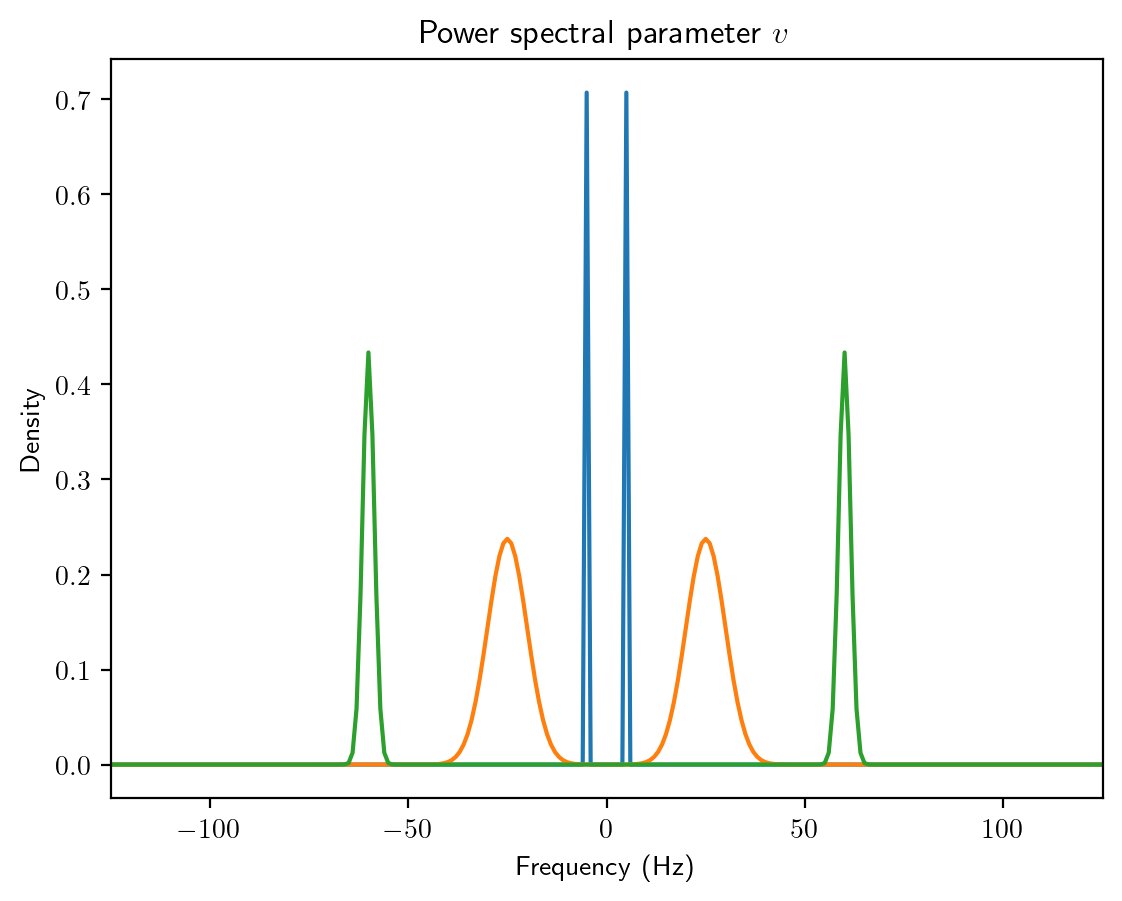

In [43]:
plt.plot(freqs, v.T)
plt.xlim(-125, 125)
plt.title("Power spectral parameter $v$")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density");

Now, we can plot what the data for this frequency distribution looks like before scaling by $f$. To do that, though, we need to put $v$ back into "correct" (`np.fft` convention) frequency order:

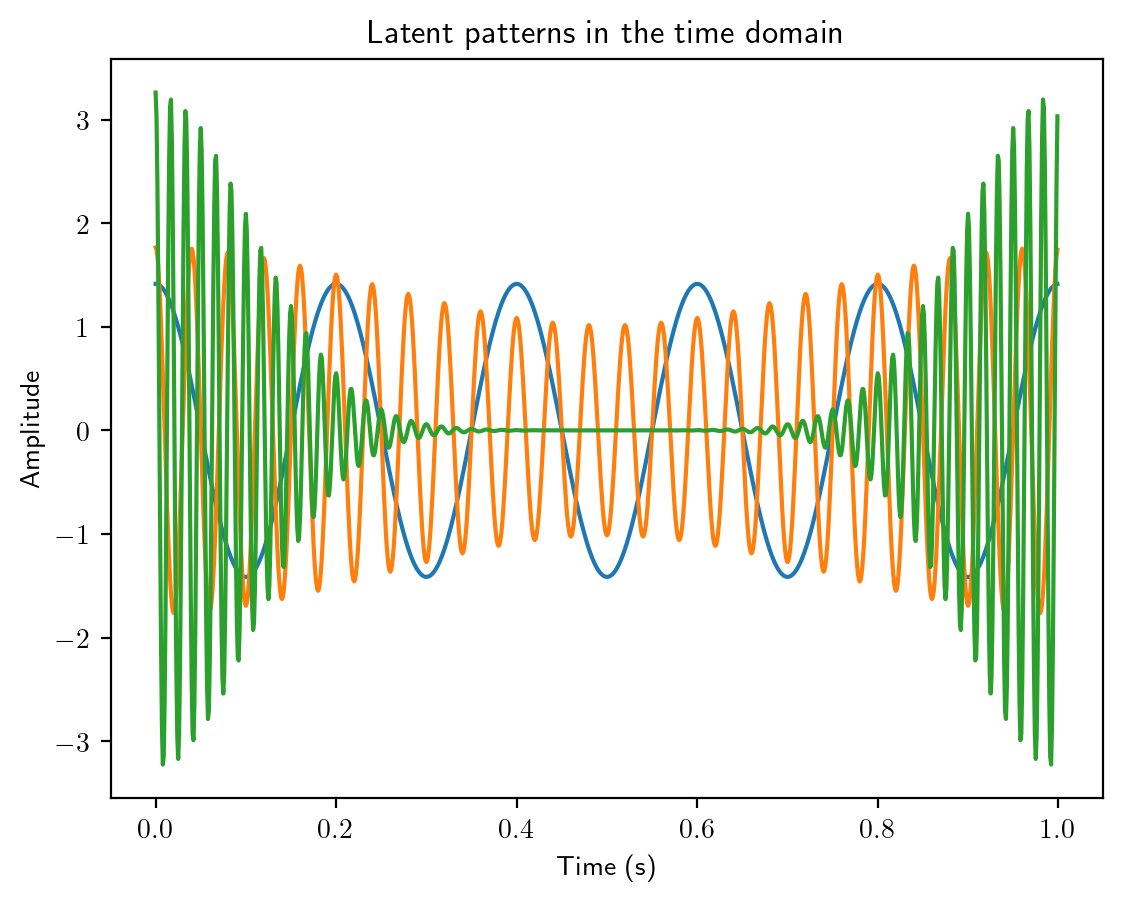

In [61]:
vv = np.fft.ifftshift(v, axes=1)
s = np.fft.fft(vv)
s = np.real(s)  # real parts should be very near 0
taxis = np.arange(0, N * dt, dt)
plt.plot(taxis, s.T);
plt.title("Latent patterns in the time domain")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude");

And we want to mix this with a dictionary matrix $\mathbf{D}$ with normalized columns to get the data:

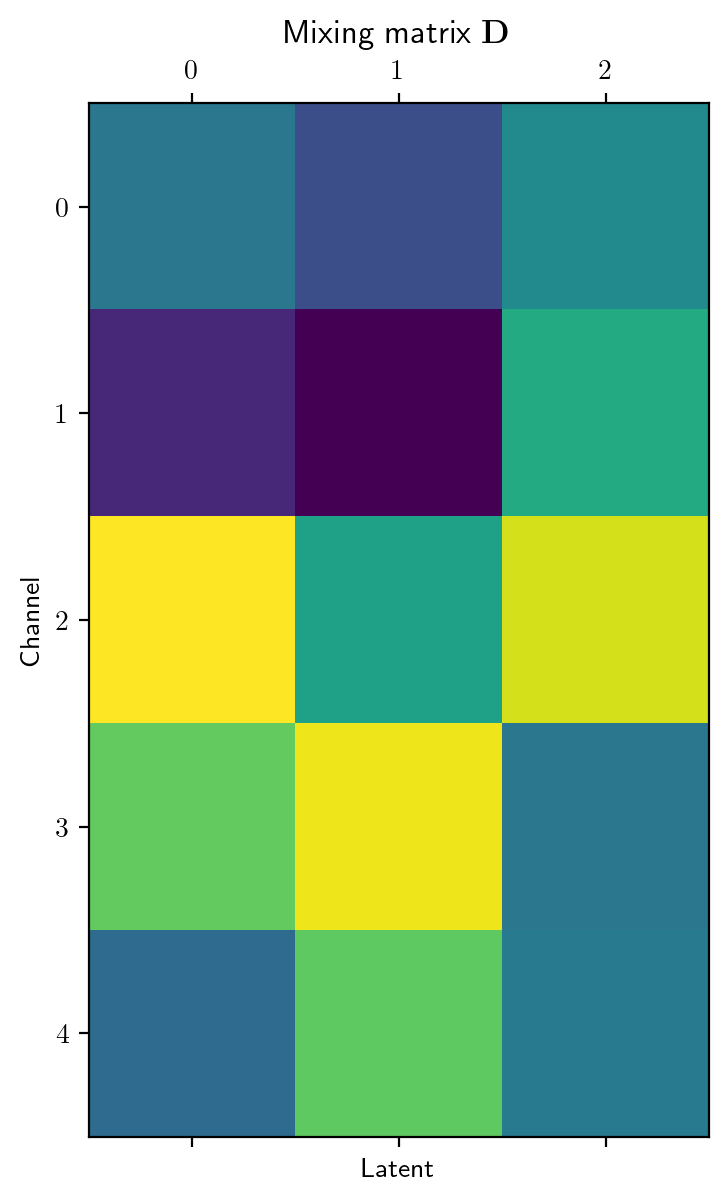

In [59]:
Nchan = 5
D = np.random.rand(Nchan, Nlat)
D /= np.linalg.norm(D, axis=0)
plt.matshow(D)
plt.title(r"Mixing matrix $\mathbf{D}$")
plt.xlabel("Latent")
plt.ylabel("Channel");

Finally, we make $\mathbf{X}$ as the mixed data. For simplicity, we will take $f = 1$:

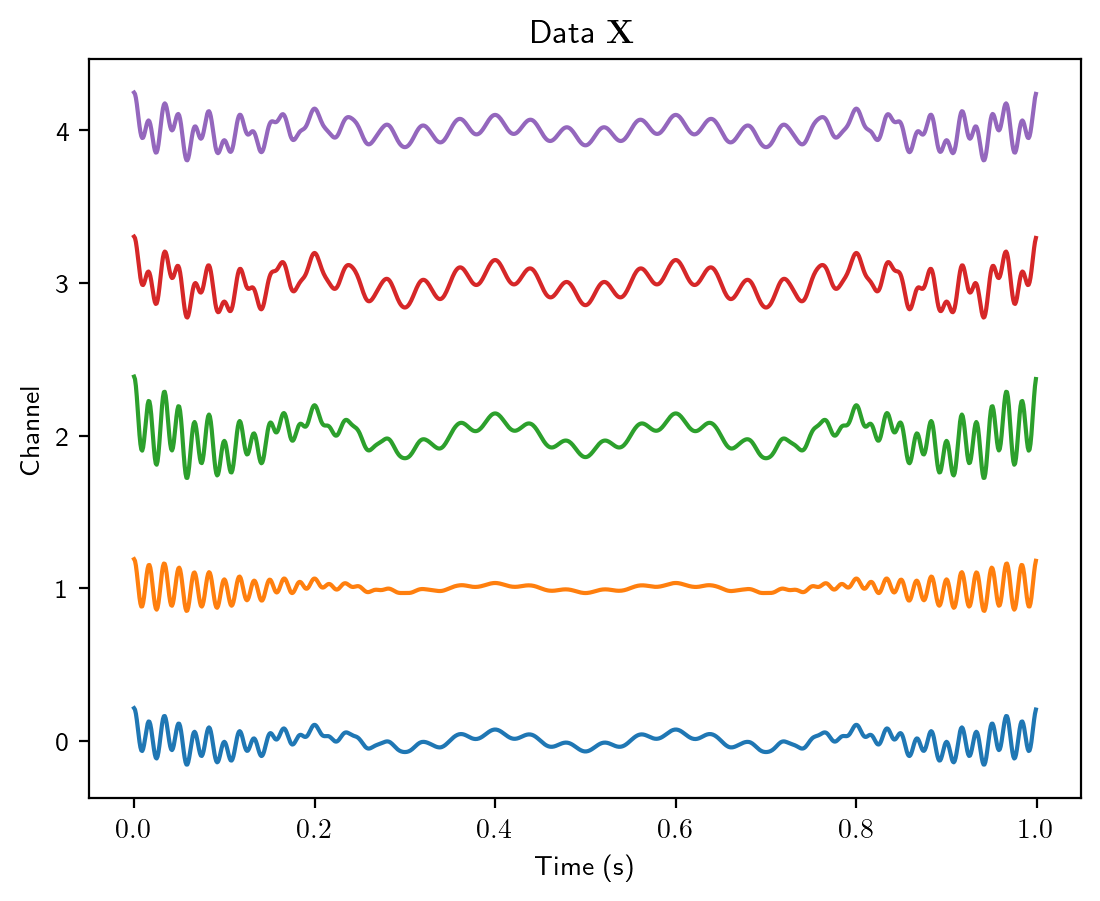

In [78]:
x = D @ s
plt.plot(taxis, (x + 10 * np.arange(Nchan)[:, np.newaxis]).T);
plt.title(r"Data $\mathbf{X}$")
plt.xlabel("Time (s)")
plt.ylabel("Channel")
plt.gca().set_yticks(10 * np.arange(Nchan));
plt.gca().set_yticklabels(range(Nchan));